In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv("new_data.csv", low_memory='False')

C:\Users\ТарасоваСофияАльберт\AppData\Local\Temp\ipykernel_10356\781481149.py:1: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("new_data.csv", low_memory='False')


In [3]:
df.shape

(288081, 145)

## Create LGD

In [4]:
df['lgd']=1-(df['total_rec_prncp'])/df['loan_amnt']

In [5]:
df.lgd.describe()

count    288081.000000
mean          0.693658
std           0.221226
min           0.000000
25%           0.560656
50%           0.744270
75%           0.870504
max           1.000000
Name: lgd, dtype: float64

## Credit info 

In [6]:
# Create list of datetime columns
datetime_cols = ['earliest_cr_line', 'issue_d']

# Convert to datetime
df[datetime_cols] = df[datetime_cols].apply(pd.to_datetime)

In [7]:
# fill the missing value for earliest_cr_line with most frequently occuring
df['earliest_cr_line'].fillna(df['earliest_cr_line'].value_counts().index[0], inplace=True)

df['credit_hist_in_months'] = ((df['issue_d'] - df['earliest_cr_line'])/np.timedelta64(1, 'M'))
df['credit_hist_in_months'] = df['credit_hist_in_months'].astype(int)

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,lgd,credit_hist_in_months
0,NaN,NaN,20975,20975,20975.0,36 months,8.19,659.13,A,A4,Project Director,2 years,MORTGAGE,165000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,debt_consolidation,Debt consolidation,194xx,PA,24.27,0.0,1997-10-01,0.0,NaN,NaN,9.0,0.0,4210,16.6,21.0,w,20975.0,20975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,319246.0,0.0,2.0,1.0,2.0,11.0,67142.0,NaN,0.0,2.0,3004.0,17.0,25300.0,1.0,2.0,1.0,6.0,35472.0,4496.0,40.1,0.0,0.0,138.0,211.0,14.0,11.0,3.0,14.0,NaN,11.0,NaN,0.0,1.0,3.0,1.0,5.0,4.0,4.0,13.0,3.0,9.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,378104.0,111136.0,7500.0,85932.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,254
1,NaN,NaN,20000,20000,20000.0,36 months,11.80,662.38,B,B4,Dental Hygienist,3 years,RENT,50000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,vacation,Vacation,276xx,NC,9.18,0.0,2003-08-01,1.0,NaN,NaN,17.0,0.0,16576,13.9,26.0,w,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,65731.0,1.0,1.0,0.0,0.0,98.0,49155.0,NaN,2.0,4.0,4383.0,14.0,119400.0,0.0,1.0,6.0,4.0,4382.0,77204.0,15.3,0.0,0.0,114.0,184.0,6.0,6.0,0.0,7.0,NaN,1.0,NaN,0.0,6.0,7.0,11.0,15.0,2.0,16.0,24.0,7.0,17.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,164900.0,65731.0,91200.0,45500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,184
2,NaN,NaN,9100,9100,9100.0,36 months,26.31,368.15,E,E4,Rural carrier,3 years,OWN,62000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,other,Other

In [8]:
# Create a new binary feature of whether or not there is a bankruptcy on file in customers credit history
df['cb_person_bk_on_file_Y'] = df['pub_rec_bankruptcies'].apply(lambda x: 1 if x >= 1 else 0)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,lgd,credit_hist_in_months,cb_person_bk_on_file_Y
0,NaN,NaN,20975,20975,20975.0,36 months,8.19,659.13,A,A4,Project Director,2 years,MORTGAGE,165000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,debt_consolidation,Debt consolidation,194xx,PA,24.27,0.0,1997-10-01,0.0,NaN,NaN,9.0,0.0,4210,16.6,21.0,w,20975.0,20975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,319246.0,0.0,2.0,1.0,2.0,11.0,67142.0,NaN,0.0,2.0,3004.0,17.0,25300.0,1.0,2.0,1.0,6.0,35472.0,4496.0,40.1,0.0,0.0,138.0,211.0,14.0,11.0,3.0,14.0,NaN,11.0,NaN,0.0,1.0,3.0,1.0,5.0,4.0,4.0,13.0,3.0,9.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,378104.0,111136.0,7500.0,85932.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,254,0
1,NaN,NaN,20000,20000,20000.0,36 months,11.80,662.38,B,B4,Dental Hygienist,3 years,RENT,50000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,vacation,Vacation,276xx,NC,9.18,0.0,2003-08-01,1.0,NaN,NaN,17.0,0.0,16576,13.9,26.0,w,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,65731.0,1.0,1.0,0.0,0.0,98.0,49155.0,NaN,2.0,4.0,4383.0,14.0,119400.0,0.0,1.0,6.0,4.0,4382.0,77204.0,15.3,0.0,0.0,114.0,184.0,6.0,6.0,0.0,7.0,NaN,1.0,NaN,0.0,6.0,7.0,11.0,15.0,2.0,16.0,24.0,7.0,17.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,164900.0,65731.0,91200.0,45500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,184,0
2,NaN,NaN,9100,9100,9100.0,36 months,26.31,368.15,E,E4,Rural carrier,3 years,OWN,62000.0,Verified,2018-12-01,Late (31-120 

## Term

In [9]:
# Convert values of term to 0, 1 where 0 = 36 months and 1 = 60 months
df['term'] = df['term'].replace({' 36 months': '0',
                                                       ' 60 months': '1'})

# convert term into an integer data type 
df['term'] = df['term'].astype(int)

## Home ownership

In [10]:
# create emp_length dummy data frame
home_ownership = pd.DataFrame(pd.get_dummies(df['home_ownership'], prefix='home_ownership'))

# join the loan_amnt dummy dataframe to conditions_df
df = pd.concat([df, home_ownership], axis=1, sort=False)

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,lgd,credit_hist_in_months,cb_person_bk_on_file_Y,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,NaN,NaN,20975,20975,20975.0,0,8.19,659.13,A,A4,Project Director,2 years,MORTGAGE,165000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,debt_consolidation,Debt consolidation,194xx,PA,24.27,0.0,1997-10-01,0.0,NaN,NaN,9.0,0.0,4210,16.6,21.0,w,20975.0,20975.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,319246.0,0.0,2.0,1.0,2.0,11.0,67142.0,NaN,0.0,2.0,3004.0,17.0,25300.0,1.0,2.0,1.0,6.0,35472.0,4496.0,40.1,0.0,0.0,138.0,211.0,14.0,11.0,3.0,14.0,NaN,11.0,NaN,0.0,1.0,3.0,1.0,5.0,4.0,4.0,13.0,3.0,9.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,378104.0,111136.0,7500.0,85932.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,254,0,0,1,0,0,0,0
1,NaN,NaN,20000,20000,20000.0,0,11.80,662.38,B,B4,Dental Hygienist,3 years,RENT,50000.0,Verified,2018-12-01,Late (31-120 days),n,NaN,NaN,vacation,Vacation,276xx,NC,9.18,0.0,2003-08-01,1.0,NaN,NaN,17.0,0.0,16576,13.9,26.0,w,20000.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,65731.0,1.0,1.0,0.0,0.0,98.0,49155.0,NaN,2.0,4.0,4383.0,14.0,119400.0,0.0,1.0,6.0,4.0,4382.0,77204.0,15.3,0.0,0.0,114.0,184.0,6.0,6.0,0.0,7.0,NaN,1.0,NaN,0.0,6.0,7.0,11.0,15.0,2.0,16.0,24.0,7.0,17.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,164900.0,65731.0,91200.0,45500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,184,0,0,0

## Create train and target

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.25, train_size = 0.75, shuffle = True, random_state = 42)
df['data_type'] = ''
df.loc[train.index, 'data_type'] = 'train'
df.loc[test.index, 'data_type'] = 'test'

## Encodings

In [12]:
from category_encoders.target_encoder import TargetEncoder
enc = TargetEncoder()

cat_features = ['grade', 'emp_title', 'purpose']
cat_features_mte = ['grade_mte', 'emp_title_mte', 'purpose_mte']

enc = enc.fit(df.loc[df.data_type == 'train', cat_features], df.loc[df.data_type == 'train', 'lgd'])
df[cat_features_mte] = enc.transform(df[cat_features], df.lgd)

## Numeric values

In [13]:
# Convert numeric cols into numeric data types
num_features = ['dti','annual_inc', 'int_rate', 'credit_hist_in_months']
df[num_features] = df[num_features].apply(pd.to_numeric)

# fill missing values for dti with the mean
df['dti'] = df['dti'].fillna(df['dti'].mean())

## Some data exploration

<AxesSubplot:xlabel='grade'>

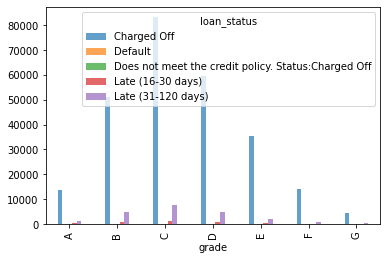

In [14]:
grade_default = pd.crosstab(df['grade'], df['loan_status'] )

fig, ax = plt.subplots()

grade_default.plot.bar(legend=True, alpha=0.7, ax=ax)

## Create final dataset

In [15]:
columns_used = ['lgd', 'credit_hist_in_months', 'cb_person_bk_on_file_Y', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'data_type','grade_mte', 'emp_title_mte','purpose_mte', 'term','int_rate', 'annual_inc', 'dti' ]
#c_u = ['lgd','term','int_rate', 'grade_mte', 'emp_title_mte','data_type']
final_df = df[columns_used]
#final_df = final_df[final_df['lgd']]
#final_df['lgd']=1-final_df['lgd']

(array([ 3510.,  6689.,  9967., 14814., 21003., 28515., 38200., 50469.,
        61629., 53285.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

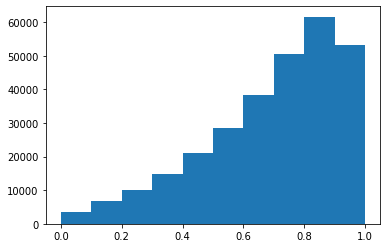

In [16]:
plt.hist(final_df['lgd'])

In [17]:
final_df.head()

,lgd,credit_hist_in_months,cb_person_bk_on_file_Y,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,data_type,grade_mte,emp_title_mte,purpose_mte,term,int_rate,annual_inc,dti
0,1.0,254,0,0,1,0,0,0,0,test,0.579961,0.633712,0.696740,0,8.19,165000.0,24.27
1,1.0,184,0,0,0,0,0,0,1,train,0.621698,0.679609,0.680762,0,11.80,50000.0,9.18
2,1.0,180,0,0,0,0,0,1,0,train,0.766107,0.735008,0.709505,0,26.31,62000.0,13.38
3,1.0,58,0,0,1,0,0,0,0,train,0.766107,0.693636,0.696740,0,25.34,150000.0,14.25
4,1.0,109,0,0,0,0,0,0,1,test,0.679197,0.693636,0.696740,0,13.56,33000.0,2.55


## Correlation

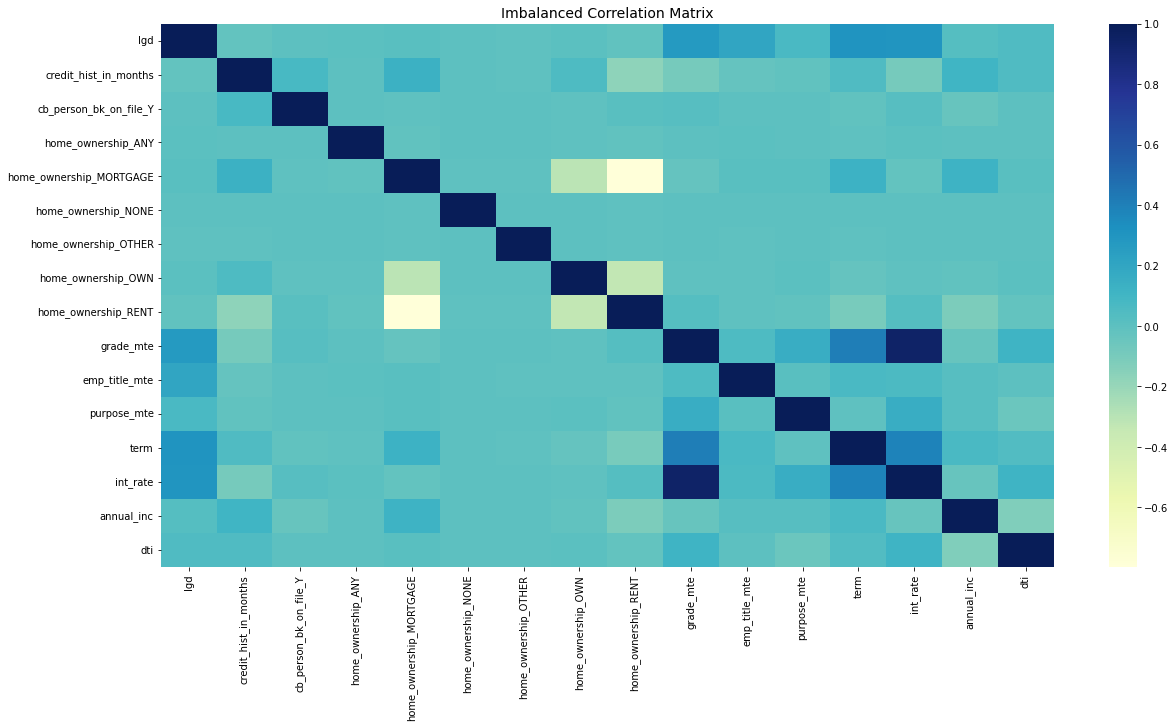

In [18]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = final_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()

## Normalization 

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = final_df[final_df['data_type']=='train']
x_test = final_df[final_df['data_type']=='test']

y_train = x_train['lgd']
x_train = x_train.drop(['lgd', 'data_type'], axis=1)

y_test = x_test['lgd']
x_test = x_test.drop(['lgd', 'data_type'], axis=1)


In [20]:
x_train[num_features+cat_features_mte] = scaler.fit_transform(x_train[num_features+cat_features_mte])
x_test[num_features+cat_features_mte] = scaler.transform(x_test[num_features+cat_features_mte])

In [20]:
x_train.head()

,credit_hist_in_months,cb_person_bk_on_file_Y,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,grade_mte,emp_title_mte,purpose_mte,term,int_rate,annual_inc,dti
1,0.212230,0,0,0,0,0,0,1,0.156722,0.635057,0.261518,0,0.252726,0.005263,0.009189
2,0.207434,0,0,0,0,0,1,0,0.698987,0.713599,0.588829,0,0.817757,0.006526,0.013393
3,0.061151,0,0,1,0,0,0,0,0.698987,0.654944,0.443470,0,0.779984,0.015789,0.014264
5,0.230216,0,0,1,0,0,0,0,0.000000,0.684115,0.081850,0,0.044782,0.005789,0.017848
7,0.244604,0,0,0,0,0,0,1,0.698987,0.654944,0.443470,1,0.817757,0.007368,0.039199


## Lin Regression 

In [21]:
# Create, train, and fit a logistic regression model
from sklearn.linear_model import LinearRegression
clf_linear = LinearRegression().fit(x_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
lr_preds = clf_linear.predict(x_test)

# # Create dataframes of predictions and true labels
lr_preds_df = pd.DataFrame(lr_preds[0:], columns = ['lr_pred_PD'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), lr_preds_df], axis = 1))

            lgd  lr_pred_PD
0      1.000000    0.546204
1      1.000000    0.623108
2      1.000000    0.695007
3      1.000000    0.698181
4      1.000000    0.683441
...         ...         ...
72016  0.699283    0.704956
72017  0.917822    0.761169
72018  0.868670    0.951233
72019  0.771147    0.702972
72020  0.696186    0.673828

[72021 rows x 2 columns]


In [22]:
r_sq = clf_linear.score(x_test, true_df)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {clf_linear.intercept_}")
print(f"coefficients: {clf_linear.coef_}")

coefficient of determination: 0.10996736603499291
intercept: 168226756354.37872
coefficients: [-1.41100448e-02  1.20511977e-04 -1.68226756e+11 -1.68226756e+11
 -1.68226756e+11 -1.68226756e+11 -1.68226756e+11 -1.68226756e+11
 -1.58253721e-01  6.91656811e-01  5.20868017e-02  9.86307838e-02
  4.01245183e-01  4.14910405e-01  3.92058298e-01]


## XGBoost

In [21]:
from category_encoders import TargetEncoder, WOEEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
import xgboost as xgb

params = {
    'max_depth':[2,3],
    'min_child_weight': [1, 10, 100],
    'eta': [0.05, 0.3, 0.5],
    'subsample': [1, 0.3],
    'colsample_bytree': [1, 0.8],
    'gamma': [0, 0.5],
    'lambda': [1, 5, 10], 
    'alpha': [0, 1, 3]
}

In [22]:
xgb_1 = XGBRegressor(objective = 'reg:linear', eval_metric = 'rmse')
xgb_grid = RandomizedSearchCV(xgb_1, params, cv = 3, n_jobs = 5, verbose=True)

xgb_grid.fit(x_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[11:23:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
0.1705655845828841
{'subsample': 1, 'min_child_weight': 10, 'max_depth': 2, 'lambda': 5, 'gamma': 0, 'eta': 0.3, 'colsample_bytree': 0.8, 'alpha': 1}


In [23]:
best_params = xgb_grid.best_params_
best_params['objective'] = 'reg:linear'
best_params['eval_metric'] = 'rmse'

In [24]:
model = xgb.train(best_params,
                      xgb.DMatrix(x_train, label = y_train)
                 )
test['base_pred'] = model.predict(xgb.DMatrix(x_test))
train['base_pred'] = model.predict(xgb.DMatrix(x_train))

[11:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, train['base_pred'])

0.04017810729814497

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
mean_squared_error(y_test, test['base_pred'])

0.04304499947523855

## SHAP

In [38]:
import shap

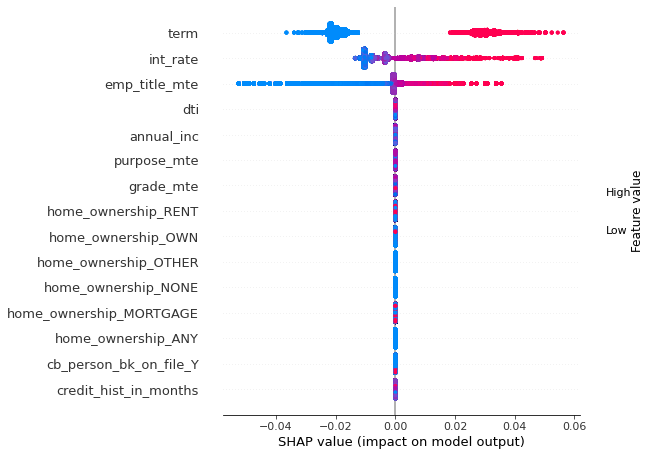

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(xgb.DMatrix(x_train))
shap.summary_plot(shap_values, x_train)